In [67]:
import pandas as pd
import networkx as nx
import random
import math
import matplotlib.pyplot as plt
from collections import defaultdict
from networkx.algorithms.link_prediction import (
    jaccard_coefficient,
    adamic_adar_index,
    preferential_attachment,
    resource_allocation_index,
)
from sklearn.preprocessing import MinMaxScaler

In [68]:
df = pd.read_csv("dataset.csv")  


grouped = df.groupby("userId")

train_data = []
test_data = []


for user_id, group in grouped:
    if len(group) > 1:
        test_row = group.sample(n=1)
        train_rows = group.drop(test_row.index)
        test_data.append(test_row)
        train_data.append(train_rows)
    else:
      
        train_data.append(group)


train_df = pd.concat(train_data).reset_index(drop=True)
test_df = pd.concat(test_data).reset_index(drop=True)
mypairs = list(zip(test_df["userId"], test_df["movieId"]))

train_df.to_csv("train_dataset.csv", index=False)
test_df.to_csv("test_dataset.csv", index=False)



In [69]:

train_df = pd.read_csv("train_dataset.csv")


B = nx.Graph()
user_nodes = train_df['userId'].unique()
movie_nodes = train_df['movieId'].unique()

B.add_nodes_from(user_nodes, bipartite='user')
B.add_nodes_from(movie_nodes, bipartite='movie')


edges = list(train_df.itertuples(index=False, name=None))
B.add_edges_from(edges)

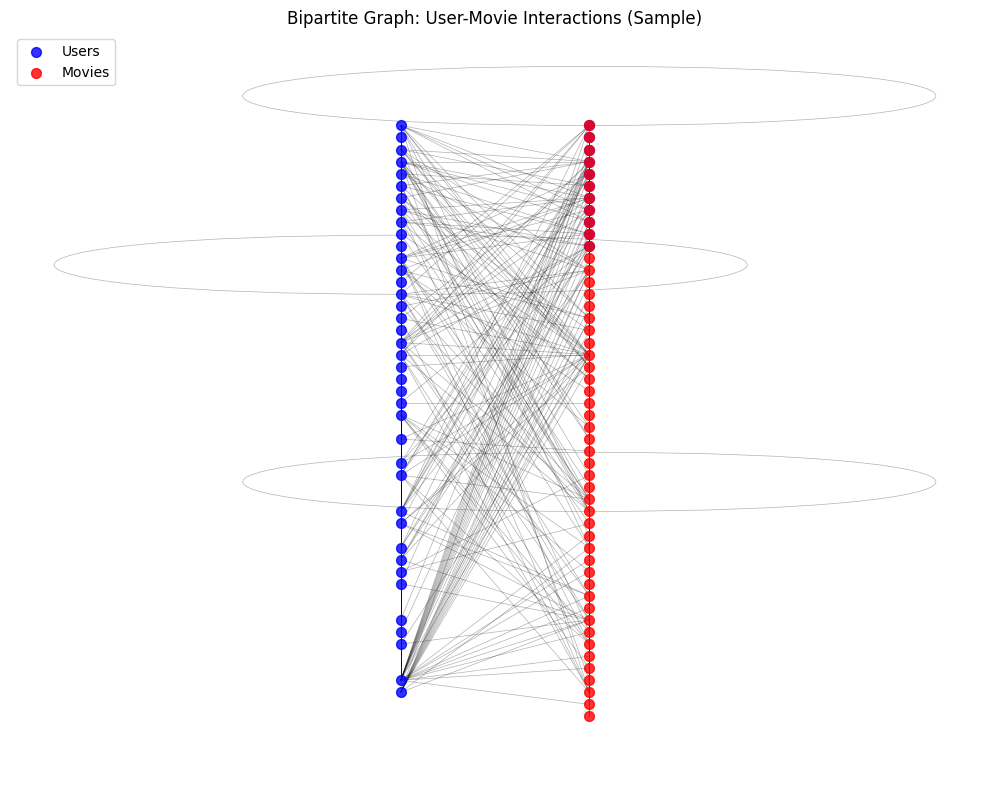

In [70]:

def plot_bipartite_graph(B, user_nodes, movie_nodes, sample_size=None):
   
    if sample_size and (len(user_nodes) > sample_size or len(movie_nodes) > sample_size):
        users_sample = list(user_nodes)[:min(sample_size, len(user_nodes))]
        movies_sample = list(movie_nodes)[:min(sample_size, len(movie_nodes))]
        
       
        subgraph_nodes = users_sample + movies_sample
        B_sample = B.subgraph(subgraph_nodes)
    else:
        B_sample = B
        users_sample = user_nodes
        movies_sample = movie_nodes
    
  
    pos = {}
    
    
    pos.update((node, (1, i)) for i, node in enumerate(users_sample))
    
  
    pos.update((node, (2, i)) for i, node in enumerate(movies_sample))
    
    plt.figure(figsize=(10, 8))
    
  
    nx.draw_networkx_nodes(B_sample, pos, nodelist=users_sample, 
                           node_color='blue', node_size=50, alpha=0.8, label='Users')
    nx.draw_networkx_nodes(B_sample, pos, nodelist=movies_sample, 
                           node_color='red', node_size=50, alpha=0.8, label='Movies')
    
    
    nx.draw_networkx_edges(B_sample, pos, width=0.5, alpha=0.3)
    
  
    if len(B_sample) < 50:
        nx.draw_networkx_labels(B_sample, pos, font_size=8)
    
    plt.title(f"Bipartite Graph: User-Movie Interactions (Sample)")
    plt.legend()
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


plot_bipartite_graph(B, user_nodes, movie_nodes, sample_size=50)

In [71]:
def custom_jaccard(B, u, v):
    neighbors_u = set(B[u])
    neighbors_v = set(B[v])
    union = neighbors_u | neighbors_v
    intersection = neighbors_u & neighbors_v
    if len(union) == 0:
        return 0.0
    return len(intersection) / len(union)

def custom_adamic_adar(B, u, v):
    neighbors_u = set(B[u])
    neighbors_v = set(B[v])
    common = neighbors_u & neighbors_v
    score = 0.0
    for n in common:
        deg = len(B[n])
        if deg > 1:
            score += 1 / math.log(deg)
    return score

def custom_resource_allocation(B, u, v):
    neighbors_u = set(B[u])
    neighbors_v = set(B[v])
    common = neighbors_u & neighbors_v
    score = 0.0
    for n in common:
        deg = len(B[n])
        if deg > 0:
            score += 1 / deg
    return score

def compute_custom_scores(B, node_pairs, score_func):
    score_dict = defaultdict(list)
    for u, v in node_pairs:
       
            score = score_func(B, u, v)
            score_dict[u].append((v, score))
            # print(f"computed {score_func.__name__} for {u} and {v}")
       
    return score_dict


def get_sampled_non_edges(B, user_nodes, movie_nodes, n_samples_per_user=100):
    non_edges_sampled = []
    for u in user_nodes:
        # print(u)
        unseen_movies = [m for m in movie_nodes if not B.has_edge(u, m)]
        sampled = random.sample(unseen_movies, min(n_samples_per_user, len(unseen_movies)))
        non_edges_sampled.extend((u, m) for m in sampled)
    return non_edges_sampled


def get_score_dict(score_list):
    score_dict = defaultdict(list)
    for u, m, score in score_list:
        score_dict[u].append((m, score))
      
    return score_dict

sampled_non_edges = get_sampled_non_edges(B, user_nodes, movie_nodes)
sampled_non_edges_set = set(sampled_non_edges)

movie_nodes = list(movie_nodes)
for pair in mypairs:
    sampled_non_edges_set.add(pair)
    if not B.has_node(pair[1]):
        B.add_node(pair[1], bipartite=1)  
     
sampled_non_edges = list(sampled_non_edges_set)




print("jaccard start : ")
jaccard_scores = compute_custom_scores(B,sampled_non_edges,custom_jaccard)
print("jaccard Completed")
print("adamic_adar start : ")
adamic_scores = compute_custom_scores(B,sampled_non_edges,custom_adamic_adar)
print("adamic adar completed")
print("pa starts : ")
pa_scores = get_score_dict(preferential_attachment(B, sampled_non_edges))
print("pa completed")
print("ra starts : ")
ra_scores = compute_custom_scores(B,sampled_non_edges,custom_resource_allocation)
print("ra_completed")




jaccard start : 
jaccard Completed
adamic_adar start : 
adamic adar completed
pa starts : 
pa completed
ra starts : 
ra_completed


In [72]:
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
import pandas as pd


weights = {
    'jaccard': 0.001,
    'adamic': 0.001,
    'pa': 0.499,
    'ra': 0.499,
}



def normalize_score_dict(score_dict):
    all_scores = [score for scores in score_dict.values() for (_, score) in scores]
    if not all_scores:
        return score_dict
    scaler = MinMaxScaler()
    scaled_scores = scaler.fit_transform([[s] for s in all_scores]).flatten()

    norm_dict = defaultdict(list)
    idx = 0
    for user, scores in score_dict.items():
        norm_scores = [(movie, scaled_scores[idx + i]) for i, (movie, _) in enumerate(scores)]
        norm_dict[user] = norm_scores
        idx += len(scores)
    return norm_dict

jaccard_scores_norm = normalize_score_dict(jaccard_scores)
adamic_scores_norm = normalize_score_dict(adamic_scores)
pa_scores_norm = normalize_score_dict(pa_scores)
ra_scores_norm = normalize_score_dict(ra_scores)



final_similarity = defaultdict(dict)

for user in user_nodes:
    movies = set()
    for d in [jaccard_scores_norm, adamic_scores_norm, pa_scores_norm, ra_scores_norm]:
        movies.update([m for (m, _) in d.get(user, [])])
    
    for movie in movies:
        score = 0.0
        total_weight = 0.0

        if movie in dict(jaccard_scores_norm.get(user, [])):
            score += weights['jaccard'] * dict(jaccard_scores_norm[user])[movie]
            total_weight += weights['jaccard']
        if movie in dict(adamic_scores_norm.get(user, [])):
            score += weights['adamic'] * dict(adamic_scores_norm[user])[movie]
            total_weight += weights['adamic']
        if movie in dict(pa_scores_norm.get(user, [])):
            score += weights['pa'] * dict(pa_scores_norm[user])[movie]
            total_weight += weights['pa']
        if movie in dict(ra_scores_norm.get(user, [])):
            score += weights['ra'] * dict(ra_scores_norm[user])[movie]
            total_weight += weights['ra']

        if total_weight > 0:
            final_similarity[user][movie] = score / total_weight



rows = []
for user, movie_scores in final_similarity.items():
    for movie, score in movie_scores.items():
        rows.append({'userId': user, 'movieId': movie, 'similarity': score})

final_df = pd.DataFrame(rows)
final_df.to_csv("final_similarity_matrix.csv", index=False)


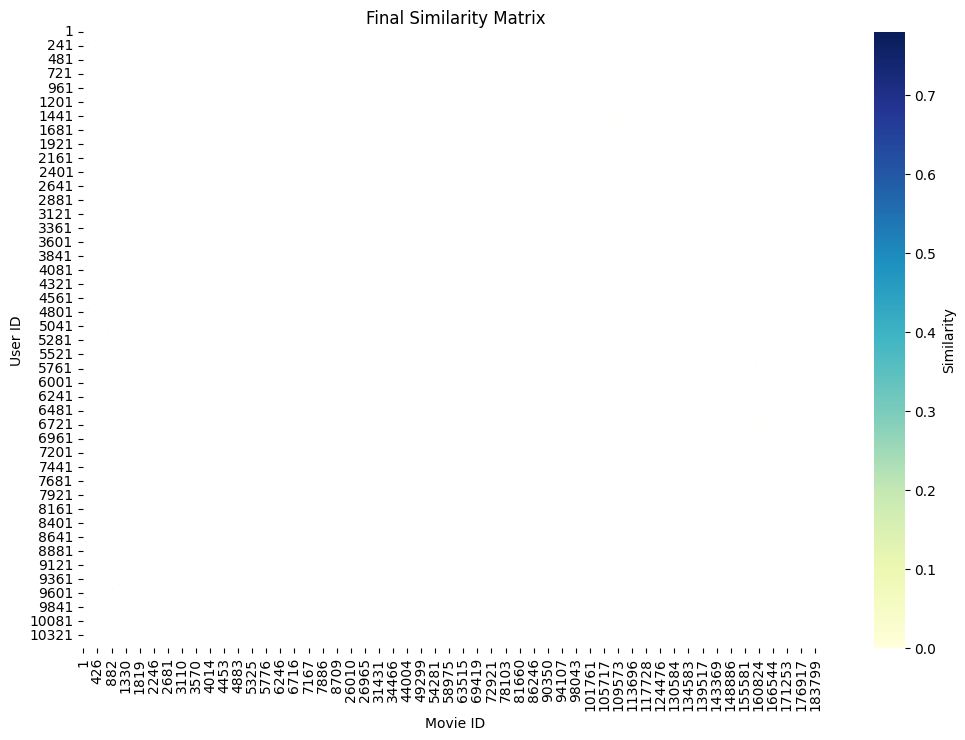

In [73]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


final_df = pd.read_csv("final_similarity_matrix.csv")


pivot_df = final_df.pivot(index='userId', columns='movieId', values='similarity')


plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, cmap="YlGnBu", annot=False, cbar_kws={'label': 'Similarity'})
plt.title('Final Similarity Matrix')
plt.xlabel('Movie ID')
plt.ylabel('User ID')
plt.show()


In [74]:


df = pd.read_csv("final_similarity_matrix.csv")


df_sorted = df.sort_values(by=["userId", "similarity"], ascending=[True, False])


top5_per_user = df_sorted.groupby("userId").head(5)


top5_per_user.to_csv("top5_recommendations.csv", index=False)




In [75]:
import pandas as pd


top5_df = pd.read_csv("top5_recommendations.csv")
test_df = pd.read_csv("test_dataset.csv")




top5_df["rank"] = top5_df.groupby("userId").cumcount() + 1


recommend_dict = top5_df.groupby("userId").apply(
    lambda x: list(zip(x["movieId"], x["rank"]))
).to_dict()


hit_count = 0
total = 0
hit_positions = []

for _, row in test_df.iterrows():
    user = row["userId"]
    true_movie = row["movieId"]
    
    if user in recommend_dict:
        recommended_movies = recommend_dict[user]
        for movie, rank in recommended_movies:
            if movie == true_movie:
                hit_count += 1
                hit_positions.append(rank)
                break
    total += 1


accuracy = hit_count / total if total > 0 else 0
print(f"🎯 تعداد کل تست‌ها: {total}")
print(f"✅ تعداد پیش‌بینی موفق: {hit_count}")
print(f"📈 دقت کلی (Top-5 Accuracy): {accuracy:.2%}")


if hit_positions:
    from collections import Counter
    rank_distribution = Counter(hit_positions)
    print("\n📊 توزیع موقعیت فیلم درست در بین پیشنهادهای top-5:")
    for rank in range(1, 6):
        print(f"  رتبه {rank}: {rank_distribution.get(rank, 0)} بار")
else:
    print("هیچ پیشنهادی درست در Top 5 نبود.")


🎯 تعداد کل تست‌ها: 10332
✅ تعداد پیش‌بینی موفق: 6508
📈 دقت کلی (Top-5 Accuracy): 62.99%

📊 توزیع موقعیت فیلم درست در بین پیشنهادهای top-5:
  رتبه 1: 2925 بار
  رتبه 2: 1360 بار
  رتبه 3: 931 بار
  رتبه 4: 722 بار
  رتبه 5: 570 بار


C:\Users\MoBa2003\AppData\Local\Temp\ipykernel_21500\3530911604.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  recommend_dict = top5_df.groupby("userId").apply(
